In [125]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pylab import rcParams
import statsmodels.api as sm

import torch

## Load the dataset
All data include the last 10 years values, coming from yahoo finance

In [113]:
google = pd.read_csv('Data/GOOG.csv', index_col='Date', parse_dates=True)
apple = pd.read_csv('Data/AAPL.csv', index_col='Date', parse_dates=True)
microsoft = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)

In [114]:
dataset = {'google': google, 'apple': apple, 'microsoft': microsoft}

## Analysis
Analysis step of the project that includes: 
1. Check for na
2. Correlation of closing and opening price
3. Attributes visualization
4. Show trend and seasonality

### NAs

In [115]:
[df.isna().sum() for _, df in dataset.items()]

[Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64]

### Correlation

There is a very high correlation between "Open" and "Close"

In [116]:
for name, df in dataset.items():
    print(f'Correlation for {name.upper()}: \n{df.corr().to_markdown()}')
    print(f"{'='}"*90)

Correlation for GOOGLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999818 |  0.999805 |  0.999576 |    0.999576 | -0.386879 |
| High      |  0.999818 |  1        |  0.999765 |  0.999801 |    0.999801 | -0.384601 |
| Low       |  0.999805 |  0.999765 |  1        |  0.999817 |    0.999817 | -0.390556 |
| Close     |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Adj Close |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Volume    | -0.386879 | -0.384601 | -0.390556 | -0.388067 |   -0.388067 |  1        |
Correlation for APPLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999878 |  0.999854 |  0.999694 |    0.9996

### Attributes visualization

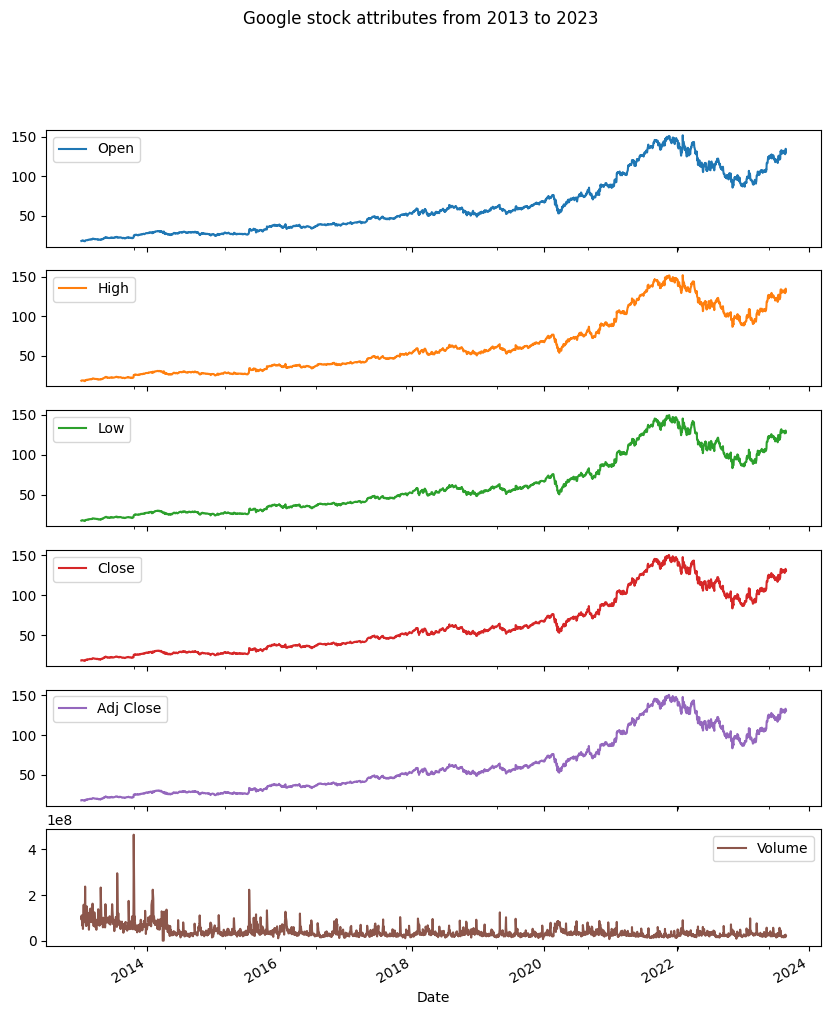

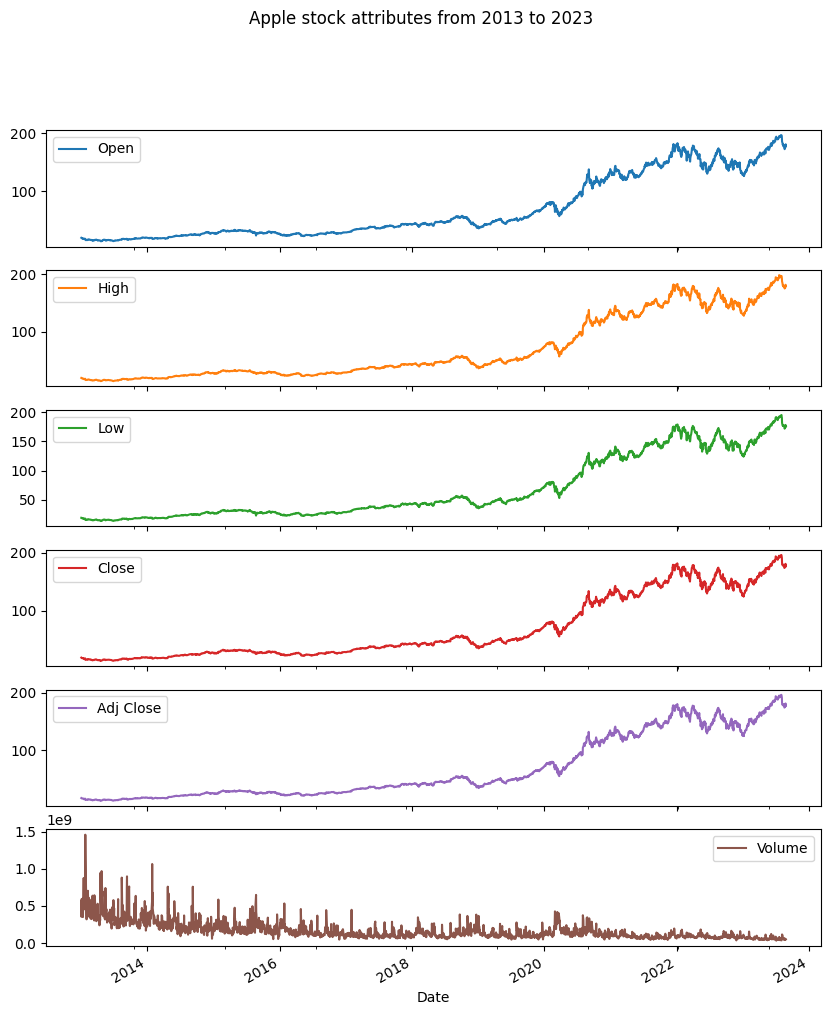

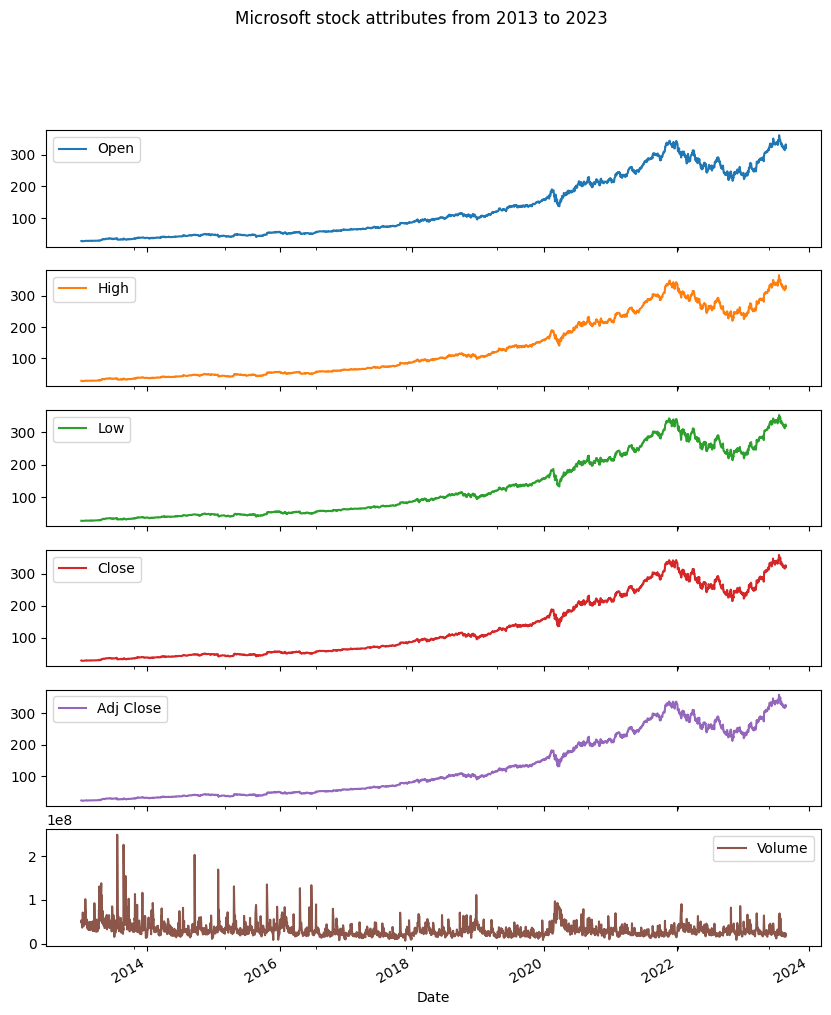

In [117]:
for name, df in dataset.items():
    df.plot(subplots=True, figsize=(10,12), title=f'{name.capitalize()} stock attributes from 2013 to 2023')
    plt.show()

#### High Plot

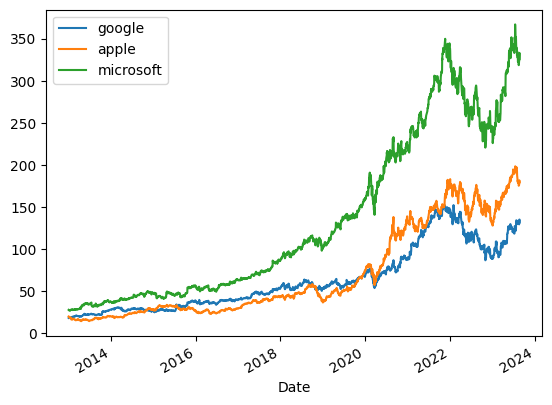

In [118]:
for _, df in dataset.items():
    df.High.plot()
plt.legend(dataset.keys())
plt.show()

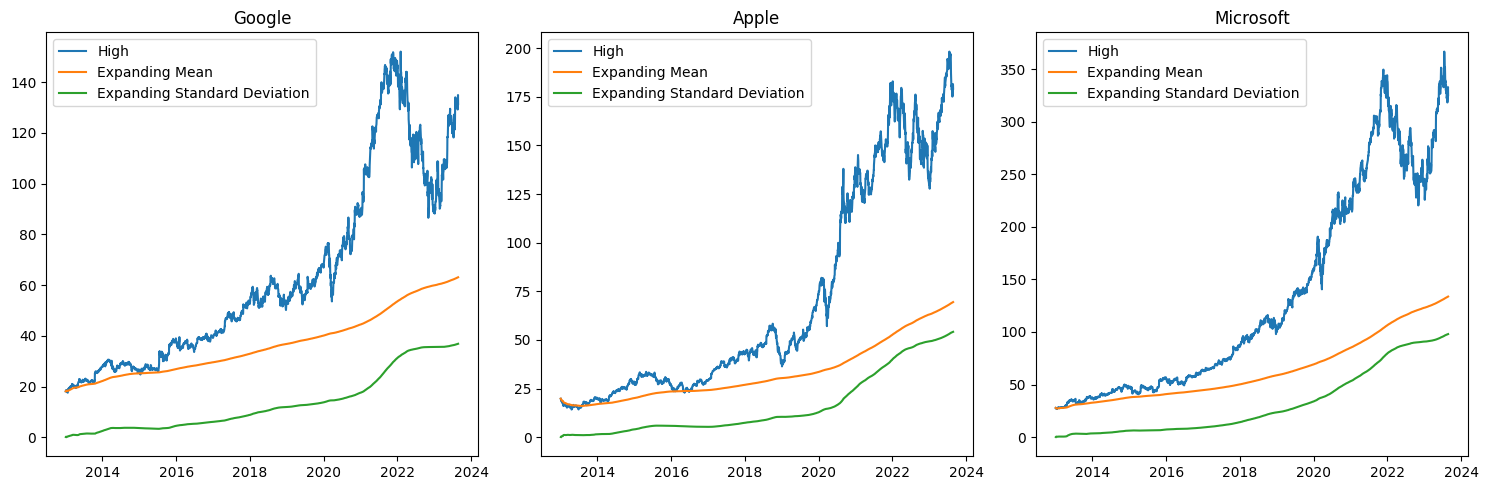

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Una riga e tre colonne

for i, data in enumerate(dataset):
    expanding_mean = dataset[data].High.expanding().mean()
    expanding_std = dataset[data].High.expanding().std()

    axs[i].plot(dataset[data].High, label='High')
    axs[i].plot(expanding_mean, label='Expanding Mean')
    axs[i].plot(expanding_std, label='Expanding Standard Deviation')
    
    axs[i].set_title(f'{data.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.show()

"High" value was never under the mean for a long time after 2016, so we can say that they have gone very well until now. Their growth is exponential.
The little decrease step in 2016 may be caused by different social factors: 
- Brexit
- U.S. Elections (November)
- Central Bank Policies

### Trend and Seasonality

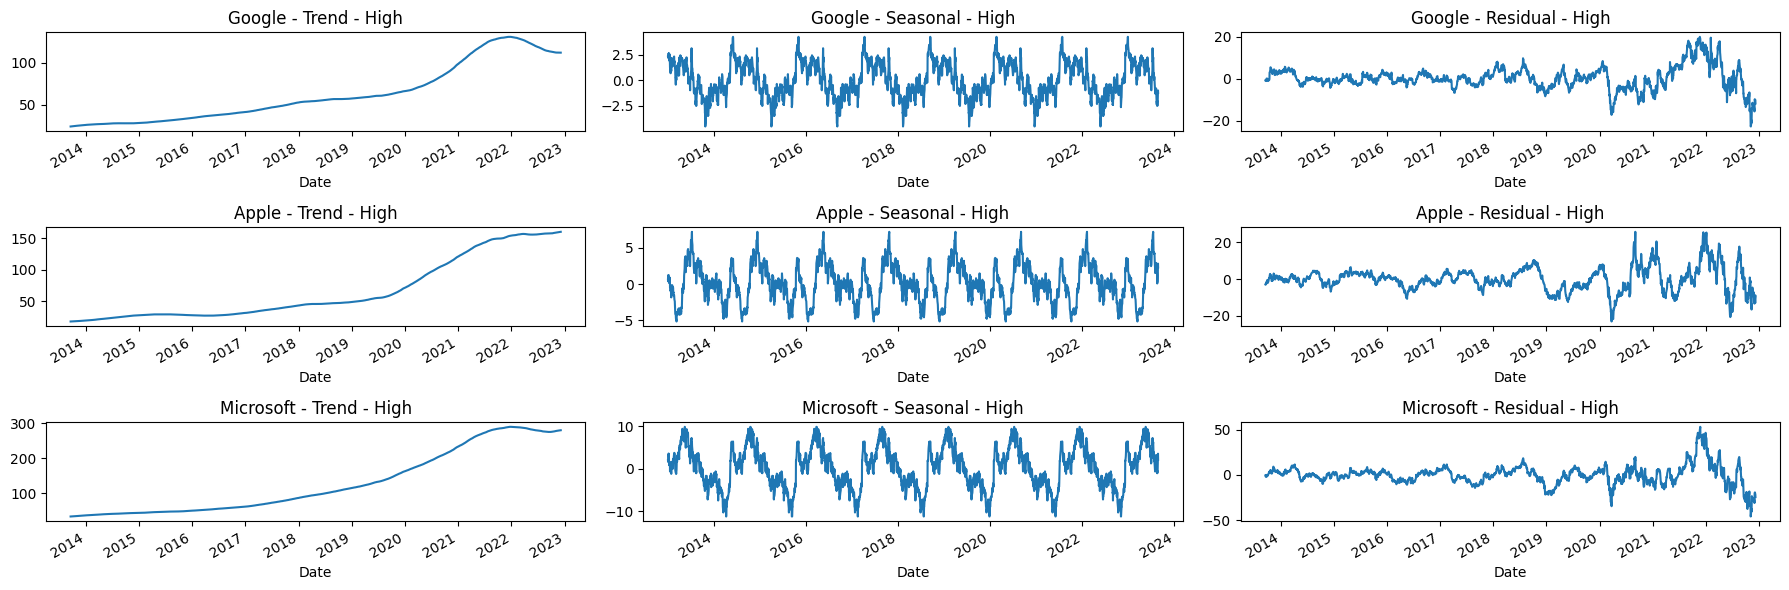

In [145]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["High"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - High")   
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - High")
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - High")
  
plt.tight_layout()
plt.show()

For all the 3 companies there is an exponential high trend after 2016 and a very high seasonality.

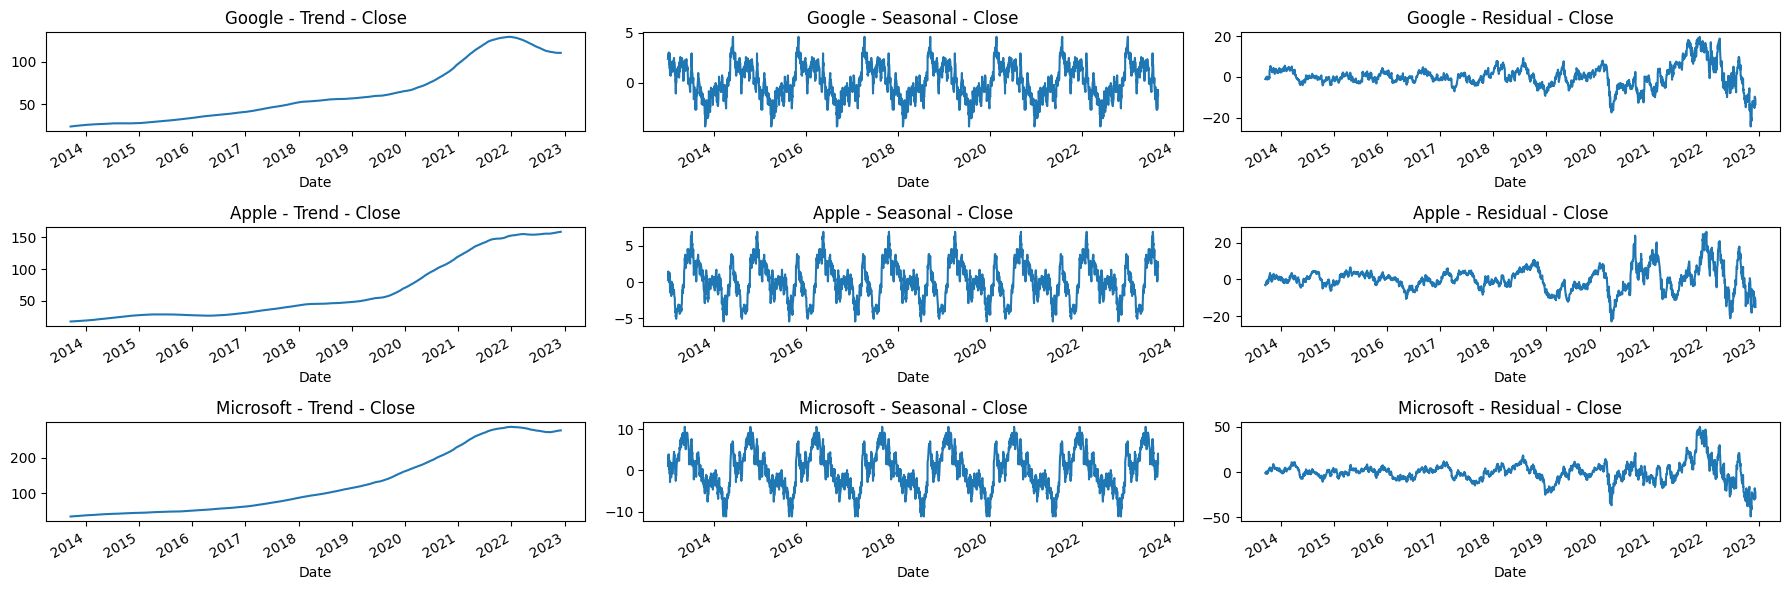

In [146]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["Close"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - Close")   
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - Close")
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - Close")
  
plt.tight_layout()
plt.show()

Since the correlation between Open and Close values is very high the trend and seasonality is very similar